## Домашнее задание №1

В этом домашнем задании вы познакомитесь с pytorch сами и сможете попрактиковаться в его применении. 

#### План:

1. Простейшие операции в pytorch
2. Пишем Adam и применяем его к ручной модели
3. Обучаем свою первую нейросеть

In [6]:
import os
import sys
import math
import torch
import random
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import numpy as np
from tqdm import tqdm
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
from IPython.display import clear_output

### Простейшие операции на pytorch (2 балла)

**Task**: Cоздайте два случайных тензора (двумерных, не квадратных):

In [2]:
x = -1.0 * torch.rand(2, 8) 
y = torch.rand(8, 6)

**Task**: Умножьте их друг на друга, результат запишите в третий тензор без использования оператора `=`, для создания третьего тензора предлагается использовать `torch.empty`:

In [3]:
z = torch.empty(2, 6)
z.set_(torch.matmul(x, y))

assert torch.equal(torch.matmul(x, y), z)

**Task**: Реализуйте ReLU использую только pytorch, примените его к тензору `x` (запрещено использование модулей torch.nn и его подмодулей, а также функции torch.relu)

In [4]:
def relu_forward(x):
    x[x < 0] = 0
    return x

assert torch.all(F.relu(x) == relu_forward(x))

In [5]:
x = relu_forward(x)

**Task**: Сделайте тоже самое c ELU (запрещено использование модулей torch.nn и его подмодулей):

In [6]:
def elu_forward(x):
    x[x < 0] = torch.exp(x[x < 0]) - 1
    return x

assert torch.allclose(
    F.elu(x),
    elu_forward(x), 
    1e-4
)

**Task**: LeakyReLU (запрещено использование модулей torch.nn и его подмодулей):

In [7]:
def lrelu_forward(x, alpha):
    x[x < 0] = alpha * x[x < 0]
    return x

assert torch.all(F.leaky_relu(x, 0.01) == lrelu_forward(x, 0.01))

**Task**: Теперь перейдем к немного более современным функциям активаций, например Mish, напомним как она выглядит:

$$x * tanh(ln(1+e^x))$$

(запрещено использование модулей torch.nn и его подмодулей)

In [8]:
def mish(x):
    return x * np.tanh(np.log(1 + np.exp(x)))

In [9]:
assert torch.allclose(
    mish(torch.tensor([1, 1, 1], dtype=torch.float32)), 
    torch.tensor([0.8651, 0.8651, 0.8651]), 
    atol=1e-4
)

assert torch.allclose(
    mish(torch.tensor([0.6376, 0.4021, 0.6656, 0.3726], dtype=torch.float64)), 
    torch.tensor([0.5014, 0.2908, 0.5280, 0.2663], dtype=torch.float64), 
    atol=1e-4
)

**Task**: Теперь реализуем swish, напомним как она выглядит:

$$x * \sigma(x)$$

(запрещено использование модулей torch.nn и его подмодулей)

In [10]:
def swish(x):
    return x * 1 / (1 + np.exp(-x))

In [11]:
assert torch.allclose(
    swish(torch.tensor([1, 1, 1], dtype=torch.float32)), 
    torch.tensor([0.7311, 0.7311, 0.7311]), 
    atol=1e-4
)

assert torch.allclose(
    swish(torch.tensor([0.6376, 0.4021, 0.6656, 0.3726], dtype=torch.float64)), 
    torch.tensor([0.4171, 0.2409, 0.4396, 0.2206], dtype=torch.float64), 
    atol=1e-4
)

### Пишем Adam и применяем его к логистической регрессии (4 балла)


В данной секции вам нужно сделать две вещи: 

1. Написать свой собственный оптимизатор подобно тому, который мы писали на семинаре
2. Обучить логистическую регрессию побатчево на картинках из датасета 


#### Adam


$$
\begin{eqnarray}
g &=& \frac{1}{m}\nabla_w \sum_i L(f(x_{i};w), y_{i}) \\
m &=& \beta_1 m + (1 - \beta_1) g \\
v &=& \beta_2 v + (1 - \beta_2) diag(gg^{T}) \\
\hat{m} &=& \frac{m}{1 - \beta_1^{t}} \\
\hat{v} &=& \frac{v}{1 - \beta_2^{t}} \\
w &=& w - \frac{\eta}{\sqrt{\hat{v} + \epsilon}} \odot \hat{m}
\end{eqnarray}
$$

In [12]:
# абстрактный класс, не обращайте внимания
from torch.optim import Optimizer

class InClassOptimizer(Optimizer):
    def step(self):
        """Perform single optimization step."""
        with torch.no_grad(): # выключим градиенты
            for group in self.param_groups:
                self._group_step(group)

    def _group_step(self, group):
        # group ~ dict[str, ...]
        """
        Private helper function to perform
        single optimization step on model parameters.
        """
        raise NotImplementedError()

**Task**: Напишите свою реализацию Adam:

In [13]:
class Adam(InClassOptimizer):
    def __init__(self, params, lr=0.001, eps=1e-13, beta_1=0.9, beta_2=0.999):
        defaults = dict(lr=lr, eps=eps, beta_1=beta_1, beta_2=beta_2, t=1)
        super().__init__(params, defaults)

    def _group_step(self, group):
        # One group contains information about values passed in init
        # and model parameters to update
        lr = group['lr']
        eps = group['eps']
        beta_1 = group['beta_1']
        beta_2 = group['beta_2']
        t = group['t']
        for param in filter(lambda x: x.grad is not None, group['params']):
            self._init_adam_buffer(param)
            m, v = self._get_adam_buffer(param)
            m.set_(m * beta_1 + (1 - beta_1) * param.grad)
            v.set_(v * beta_2 + (1 - beta_2) * param.grad**2)
            m_cap = m / (1 - beta_1**t)
            v_cap = v / (1 - beta_2**t)
            param.add_(m_cap / torch.sqrt(v_cap + eps), alpha=-lr)
        group['t'] += 1
        
    def _get_adam_buffer(self, param):
        """
        Get accumulated gradients for Adam.

        Parameters
        ----------
        param : `torch.Tensor`, required
            Model parameter to get accumulated gradeints for Adagrad.

        Returns
        -------
        Accumulated Adam gradients for parameter.
        """
        param_state = self.state[param]

        return param_state['m'], param_state['v']

    def _init_adam_buffer(self, param):
        """
        Initialize accumulated gradeints for adam.

        Parameters
        ----------
        param : `torch.Tensor`, required
            Model parameter to get accumulated gradeints for adam.
        """
        param_state = self.state[param]
        if 'm' not in param_state:
            param_state['m'] = torch.zeros_like(param)
        if 'v' not in param_state:
            param_state['v'] = torch.zeros_like(param)    

Проверим наш Optimizer на корректность, используя в качестве данных для модели воспользуемся make_regression из sklearn.

In [14]:
from sklearn.datasets import make_regression

def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

X, y = map(
    lambda x: torch.from_numpy(x).float(),
    make_regression(n_samples=200, n_features=2)
)

def get_model():
    seed_everything(42)

    return torch.nn.Sequential(
        torch.nn.Linear(2, 8),
        torch.nn.Linear(8, 6)
    )

def check_optimizer(model, optim, num_iter):
    loss = torch.nn.MSELoss()
    for i in range(num_iter):
        output = loss(model(X), y.unsqueeze(-1))
        output.backward()
        optim.step()
        optim.zero_grad()
        if i % 100 == 0:
            print(f'Iteration {i} loss:', output.item())    

In [15]:
model = get_model()
optimizer = Adam(model.parameters(), lr=0.01)
check_optimizer(model, optimizer, num_iter=1100)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([200, 1])) that is different to the input size (torch.Size([200, 6])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Iteration 0 loss: 3263.963134765625
Iteration 100 loss: 1290.9501953125
Iteration 200 loss: 3.912621259689331
Iteration 300 loss: 0.025443019345402718
Iteration 400 loss: 0.011614788323640823
Iteration 500 loss: 0.009028637781739235
Iteration 600 loss: 0.00753412488847971
Iteration 700 loss: 0.00634402921423316
Iteration 800 loss: 0.005283510312438011
Iteration 900 loss: 0.00433191517367959
Iteration 1000 loss: 0.003492513904348016


In [16]:
model = get_model()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
check_optimizer(model, optimizer, num_iter=1100)

Iteration 0 loss: 3263.963134765625


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([200, 1])) that is different to the input size (torch.Size([200, 6])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Iteration 100 loss: 1290.9500732421875
Iteration 200 loss: 3.9126172065734863
Iteration 300 loss: 0.025442952290177345
Iteration 400 loss: 0.011614780873060226
Iteration 500 loss: 0.009028682485222816
Iteration 600 loss: 0.007534132804721594
Iteration 700 loss: 0.006344052031636238
Iteration 800 loss: 0.005283525679260492
Iteration 900 loss: 0.004331957548856735
Iteration 1000 loss: 0.0034925115760415792


**Task**: Создайте параметры для обучения логистической регрессии, сделаем Xavier ициализацию, которая выглядит следующим образом: 

$$w \sim U[-\frac{\sqrt{6}}{\sqrt{n_{in} + n_{out}}}, \frac{\sqrt{6}}{\sqrt{n_{in} + n_{out}}}]$$

где: 

* $n_{in}$ -- размер входа (в нейронах) 
* $n_{out}$ -- размер выхода (в нейронах)

Подумайте над выбором $n_{in}$ и $n_{out}$ самостоятельно. 

In [17]:
def xavier(n_in, n_out):
    return torch.Tensor(n_in, n_out).uniform_(-1, 1) * math.sqrt(6./(n_in + n_out))

In [18]:
weights = xavier(784, 10)
weights.requires_grad = True
intercept = torch.ones(10, requires_grad=True)

In [19]:
optimizer = Adam([weights, intercept])
criterion = nn.CrossEntropyLoss()

Загрузим данные и создадим даталоадеры:

In [13]:
fashion_mnist_train = torchvision.datasets.FashionMNIST(
    './data',
    download=True,
    transform=transforms.Compose([transforms.ToTensor()])
)

train_dataloader = DataLoader(
    fashion_mnist_train, batch_size=128, shuffle=True, num_workers=4
)

fashion_mnist_eval = torchvision.datasets.FashionMNIST(
    './data',
    train=False,
    download=True,
    transform=transforms.Compose([transforms.ToTensor()])
)

eval_dataloader = DataLoader(
    fashion_mnist_eval, batch_size=10000, num_workers=4
)

classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw




Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Посмотрим на несколько тестовых изображений:

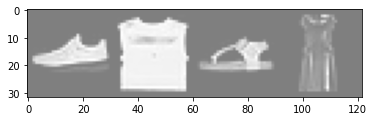

Sneaker T-shirt/top Sandal Dress


In [21]:
def imshow(img):
    img = img / 2 + 0.5  
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(DataLoader(
    fashion_mnist_train, batch_size=4, shuffle=True, num_workers=4
))

images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

Напишите функцию для тренировки логистической регрессии, она должна: 

    * Делать предсказания 
    * Считать лосс 
    * Подсчитывать градиенты
    * Делать шаг оптимизации
    * Обнулять посчитанные градиенты
    * Считать метрики 
    * Возвращать полученные метрики
    
После этого предусмотрите возможность визуализировать метрики, чтобы нарисовать картинки, а именно от вас требуется визуализировать: 

    * Зависимость лосса от количества итераций
    * Зависимость доли правильных ответов от количества итераций

In [22]:
def train_logistic_regression(weights, bias, batch, loss, optimizer):
    inputs, labels = batch
    inputs = inputs.view(inputs.shape[0], -1)

    # Обнуление посчитанных градиентов
    optimizer.zero_grad()
    # Предсказание модели
    outputs = inputs @ weights + bias
    # Подсчет loss
    loss = loss(outputs, labels)
    # Подсчет градиентов
    loss.backward()
    # Шаг оптимизации
    optimizer.step()
    # Подсчет accuracy
    _, predicted_classes = torch.max(outputs, 1)
    accuracy = (predicted_classes == labels).sum().item() / outputs.shape[0]

    return loss.item(), accuracy

In [23]:
def test_logistic_regression(weights, bias, batch, loss):
    inputs = batch[0].view(batch[0].shape[0], -1)
    labels = batch[1]

    # Предсказание модели
    outputs = inputs @ weights + bias
    # Подсчет loss
    loss = loss( outputs, labels)
    # Подсчет accuracy
    _, predicted_classes = torch.max(outputs, 1)
    accuracy = (predicted_classes == labels).sum().item() / outputs.shape[0]
    
    return loss.item(), accuracy

In [24]:
train_loss = []
train_accuracy = []
test_loss = []
test_accuracy = []

for epoch in range(0, 100): 
    running_accuracy = .0
    running_loss = .0
    # train
    for iteration, batch in enumerate(train_dataloader, 0):
        metrics = train_logistic_regression(weights, intercept, batch, criterion, optimizer)
        loss, accuracy = metrics
        running_accuracy += accuracy
        running_loss += loss
        if (iteration + 1) % 469 == 0:
            train_loss.append(running_loss / 469)
            train_accuracy.append(running_accuracy / 469)
            print('[%d epoch]\ntrain loss: %.5f | train accuracy: %.5f' % (epoch + 1, running_loss / 469, running_accuracy / 469))
            running_loss = .0
            running_accuracy = .0

    # test
    for test_batch in eval_dataloader:
        metrics = test_logistic_regression(weights, intercept, test_batch, criterion)
        loss, accuracy = metrics
        test_loss.append(loss)
        test_accuracy.append(accuracy)
        print('test loss: %.5f  | test accuracy: %.5f' % (loss, accuracy))

[1 epoch]
train loss: 0.73381 | train accuracy: 0.75975
test loss: 0.57527  | test accuracy: 0.80450
[2 epoch]
train loss: 0.51352 | train accuracy: 0.82763
test loss: 0.51451  | test accuracy: 0.82510
[3 epoch]
train loss: 0.47358 | train accuracy: 0.84089
test loss: 0.49003  | test accuracy: 0.82900
[4 epoch]
train loss: 0.45135 | train accuracy: 0.84805
test loss: 0.47663  | test accuracy: 0.83350
[5 epoch]
train loss: 0.43860 | train accuracy: 0.85080
test loss: 0.47155  | test accuracy: 0.83360
[6 epoch]
train loss: 0.42682 | train accuracy: 0.85401
test loss: 0.46194  | test accuracy: 0.83780
[7 epoch]
train loss: 0.42052 | train accuracy: 0.85680
test loss: 0.46000  | test accuracy: 0.84060
[8 epoch]
train loss: 0.41535 | train accuracy: 0.85707
test loss: 0.45494  | test accuracy: 0.83990
[9 epoch]
train loss: 0.40994 | train accuracy: 0.85950
test loss: 0.44917  | test accuracy: 0.84350
[10 epoch]
train loss: 0.40545 | train accuracy: 0.86082
test loss: 0.45526  | test accurac

#### Вопросы к секции: 

* Своими словами и без математики объясните благодаря чему Adam дает несмещенную оценку на квадрат градиента
* Когда модель начала переобучаться? Как вы это поняли? Сделайте визуализацию и докажите свою точку зрения.

Модель начала переобучаться около 15 эпохи, когда начались сильные колебания на трейне в loss и accuracy.

In [25]:
def show_plot(data, label):
    plt.rcParams["figure.figsize"] = (10, 5)
    plt.plot(data, color='purple')
    plt.ylabel(label)
    plt.xlabel('epoch')
    plt.show()

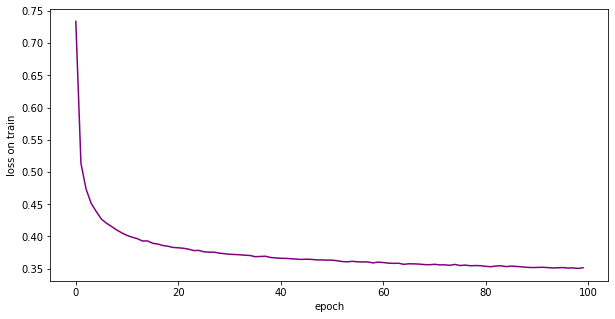

In [26]:
show_plot(train_loss, 'loss on train')

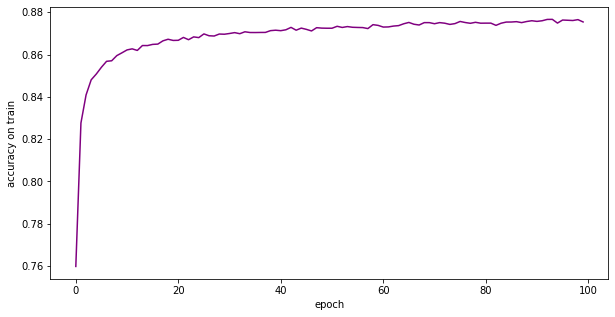

In [27]:
show_plot(train_accuracy, 'accuracy on train')

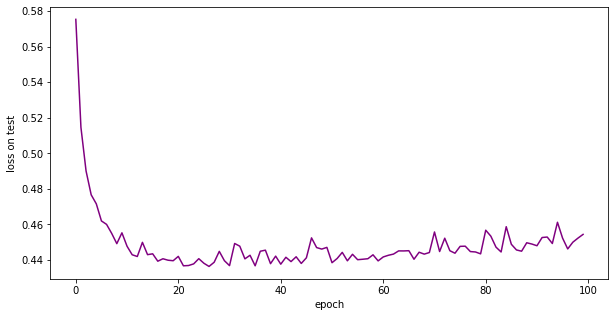

In [28]:
show_plot(test_loss, 'loss on test')

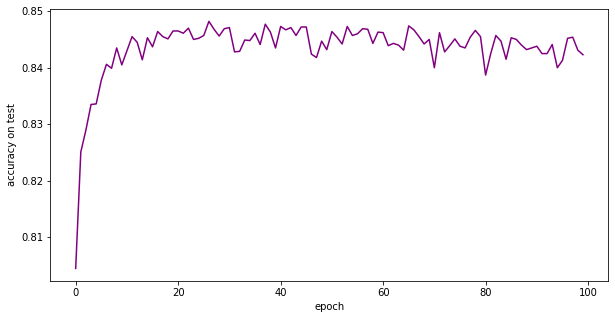

In [29]:
show_plot(test_accuracy, 'accuracy on test')

### Моя первая нейросеть (4 балла)

В данной секции вам нужно сделать следующие вещи: 

* Реализовать три разных архитектуры нейросетей. Эти архитектуры должны принципиально отличаться друг от друга. Разрешается одной из архитекур брать полностью полносвязную модель. Остальные две должны быть сверточными и сильно отличаться друг от друга. К примеру, одна из таких архитектур может быть VGG подобная сеть, а другая ResNet подобная архитектура. 

* Написать цикл для обучения которым можно обучать все три модели без изменений кода

* Попробовать каждую модель с двумя оптимизаторами: RMSprop и SGD with momentum

* Визуализировать результаты перфоманса каждой модели (две метрики минимум для каждого сетапа, например, лосс и долю правильных ответов). В данном пункте мы ждем от вас визуализацию зависимости метрики от номера итерации обучения.

* Сделать выводы какие были модели были лучше и как вы думаете почему?

In [14]:
eval_dataloader = DataLoader(
    fashion_mnist_eval, batch_size=128, num_workers=4
)

In [15]:
def plot_history(train_history, eval_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1, color='purple')
    
    points = np.array(eval_history)
    steps = list(range(0, len(train_history) + 1, int(len(train_history) / len(eval_history))))[1:]
    
    plt.scatter(steps, eval_history, marker='+', s=180, c='orange', label='eval', zorder=2)
    plt.xlabel('train steps')
    
    plt.legend(loc='best')
    plt.grid()

    plt.show()

In [20]:
def train_model(model, dataloader, optimizer):
    train_loss_log = []
    train_accuracy_log = []
    eval_loss_log = []
    eval_accuracy_log = []
    criterion = nn.CrossEntropyLoss()

    for epoch in range(0, 5):
        train_loss = .0
        train_accuracy = .0   
        train_size = 0 

        for inputs, labels in dataloader[0]:
            # Обнуление посчитанных градиентов
            optimizer.zero_grad()           
            # Предсказание модели
            outputs = model(inputs)
            train_size += outputs.size(0)  
            # Подсчет loss
            loss = criterion(outputs, labels)
            train_loss += loss.item()    
            # Подсчет градиентов
            loss.backward()
            # Шаг оптимизации
            optimizer.step()
            # Подсчет accuracy
            _, predicted_classes = torch.max(outputs, 1)
            train_accuracy += (predicted_classes == labels).sum().item()

            train_loss_log.append(loss.data / outputs.size(0))           
            train_accuracy_log.append(np.mean((predicted_classes == labels).cpu().numpy()))


        eval_loss = .0
        eval_accuracy = .0
        eval_size = 0

        with torch.no_grad():
            for inputs, labels in dataloader[1]:              
                # Предсказание модели
                outputs = model(inputs)
                eval_size += outputs.size(0)
                # Подсчет loss
                loss = criterion(outputs, labels)        
                eval_loss += loss.item()    
                # Подсчет accuracy               
                _, predicted_classes = torch.max(outputs, 1)
                eval_accuracy += (predicted_classes == labels).sum().item()

        eval_loss_log.append(eval_loss / eval_size)
        eval_accuracy_log.append(eval_accuracy / eval_size)

        clear_output()
        plot_history(train_loss_log, eval_loss_log, 'loss')
        plot_history(train_accuracy_log, eval_accuracy_log, 'accuracy')

        print('Train loss:', train_loss / train_size)
        print('Train acc:', train_accuracy / train_size)
        print('Val loss:', eval_loss / eval_size)
        print('Val acc:', eval_accuracy / eval_size)  

In [8]:
class FirstModel(nn.Module):
    def __init__(self):
        super(FirstModel, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax()

    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.softmax(self.fc3(x))

        return x

In [26]:
second_model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(16, 32, 3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.Conv2d(32, 128, 3, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(128, 128, 3, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(4608, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(64, 10),
    nn.Softmax(dim=-1)
)

In [51]:
class ResNetBlock(nn.Module):
    def __init__(self, in_size, out_size, kernel_size=3, padding=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_size, out_size, kernel_size=kernel_size, padding=padding)
        self.relu = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(out_size)
        self.conv2 = nn.Conv2d(out_size, out_size, kernel_size=kernel_size, padding=padding)
        self.bn2 = nn.BatchNorm2d(out_size)

    def forward(self, x):
        conv_block = x
        conv_block = self.relu(self.bn1(self.conv1(conv_block))) 
        conv_block = self.relu(self.bn2(self.conv2(conv_block)))
        return x + conv_block

class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        self.resblock1 = ResNetBlock(1, 32)
        self.resblock2 = ResNetBlock(32, 32)
        self.conv = nn.Conv2d(32, 10, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm2d(10)
        self.maxpool = nn.AdaptiveMaxPool2d(1)
        self.softmax = nn.Softmax()

    def forward(self, x):
        x = x.view(-1, 1, 28, 28)
        x = self.resblock1(x)
        x = self.resblock2(x) 
        x = self.conv(x)
        x = self.bn(x)
        x = self.maxpool(x)

        return x.view(x.size(0), -1)

In [18]:
def get_optimizer(model, optimizer_name='Adam', lr = 0.01, momentum=0.9):
    if optimizer_name == 'RMSprop':
        return torch.optim.RMSprop(model.parameters(), lr)
    elif optimizer_name == 'SGD':
        return torch.optim.SGD(model.parameters(), lr, momentum)
    return torch.optim.Adam(model.parameters(), lr)

## Первая модель (полносвязная)

In [57]:
def train_first_model(optimizer_name='Adam'):
    model = FirstModel()
    train_model(model, (train_dataloader, eval_dataloader), get_optimizer(model, optimizer_name))

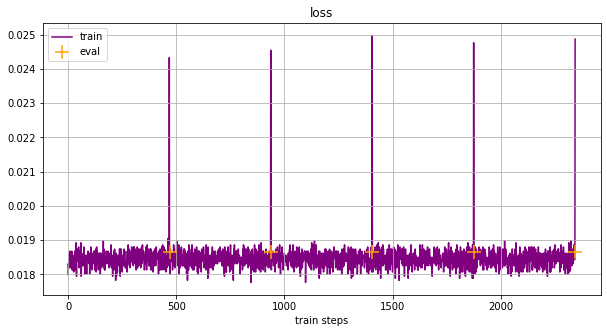

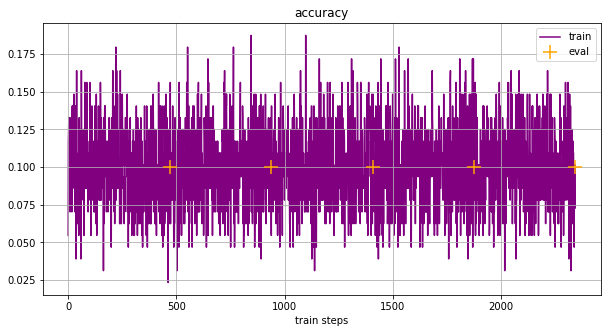

Train loss: 0.01845644226471583
Train acc: 0.1
Val loss: 0.01865637321472168
Val acc: 0.1


In [58]:
train_first_model('RMSprop')

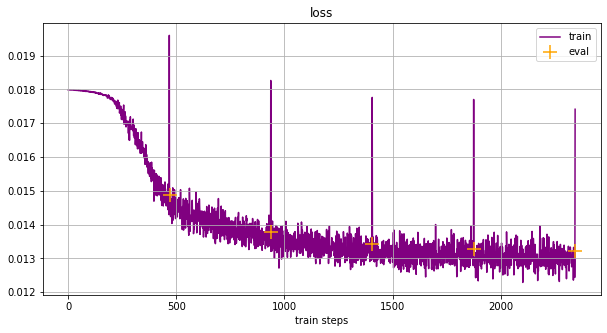

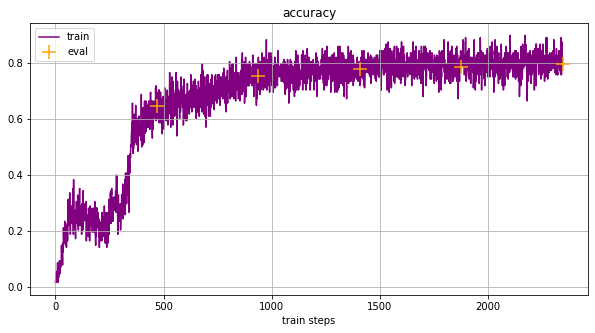

Train loss: 0.013070418026049932
Train acc: 0.7966333333333333
Val loss: 0.013212462258338928
Val acc: 0.7964


In [59]:
train_first_model('SGD')

На полносвязной модели SGD optimizer with momentum дает сильно лучшее качество по сравнению с RMSprop optimizer. Модели с RMSprop как-то прямо плоховатенько.

## Вторая модель (VGG)

In [22]:
def train_second_model(optimizer_name='Adam'):
    train_model(second_model, (train_dataloader, eval_dataloader), get_optimizer(second_model, optimizer_name))

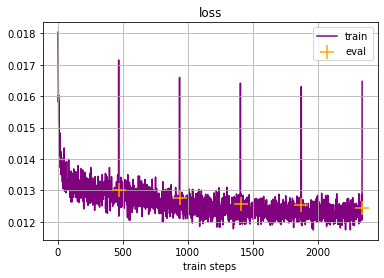

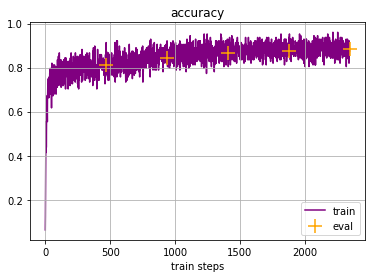

Train loss: 0.012314361002047856
Train acc: 0.8855833333333333
Val loss: 0.012456885242462159
Val acc: 0.8843


In [27]:
train_second_model('RMSprop')

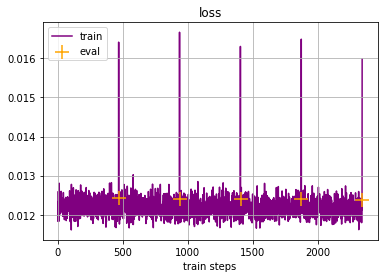

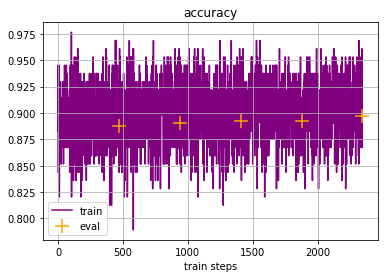

Train loss: 0.012166920757293701
Train acc: 0.9050166666666667
Val loss: 0.012374501526355743
Val acc: 0.8967


In [30]:
train_second_model('SGD')

Модель с SGD optimizer with momentum выдает чуть лучший результат, чем с RMSprop.

## Третья модель (ResNet)

In [47]:
def train_third_model(optimizer_name='Adam'):
    model = ResNet()
    train_model(model, (train_dataloader, eval_dataloader), get_optimizer(model, optimizer_name))

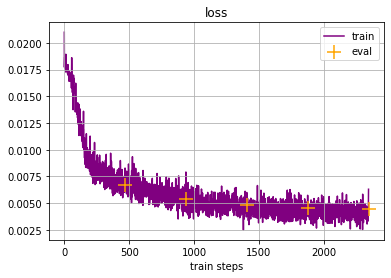

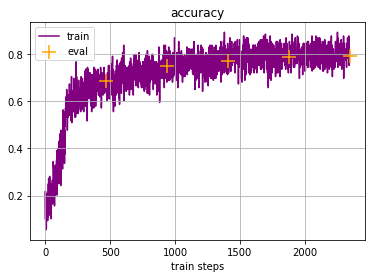

Train loss: 0.004178240069746971
Train acc: 0.7969166666666667
Val loss: 0.004477960604429245
Val acc: 0.7888


In [52]:
train_third_model('RMSprop')

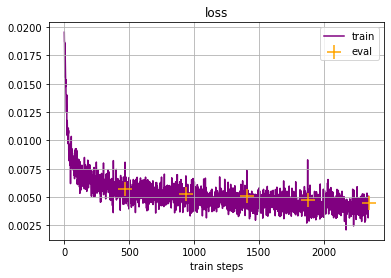

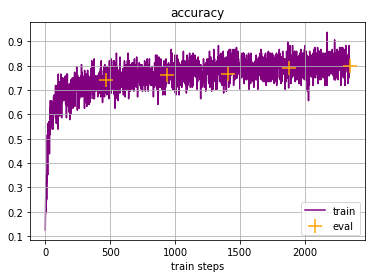

Train loss: 0.004249839826424916
Train acc: 0.8048166666666666
Val loss: 0.004488521614670753
Val acc: 0.7994


In [53]:
train_third_model('SGD')

Самой лучшей из моделей с оптимайзером SGD with momentum оказалась модель, похожая по архитектуре на VGG (accuracy = 0.8967, loss = 0.0123), далее модель ResNet (accuracy = 0.7994, loss = 0.0045), а затем полносвязная модель (accuracy = 0.7964, loss = 0.0132). 

С оптимайзером RMSprop хуже всего себя показала полносвязная модель (accuracy = 0.1, что-то пошло не так), лучше всего – VGG (accuracy = 0.8843, loss = 0.125), и чуть хуже ResNet (accuracy = 0.7888, loss = 0.0045)